### Lighter Model Version 2

#### Target:
1. Make the model lighter by replacing the last convolution layer with GAP layer.

#### Results:
1. Parameters: 7432
2. Train Accuracy: 84.65%
3. Test Accuracy: 84.42%

#### Analysis:
1. GAP helped to reduce the number of parameters to 7432 from 13832.
2. Overfitting got reduced as made model simpler with less number of parameters.
3. As network capacity got reduced, it is expected that reduction in accuracies.


### import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

### Data Statics

In [2]:
simple_transforms = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST('./data',train = True,transform=simple_transforms,download=True)
exp_data = dataset.train_data
exp_data = dataset.transform(exp_data.numpy())

print('[Train]')
print('-Numpy Shape:',dataset.train_data.cpu().numpy().shape)
print('-Tensor Shape:',dataset.train_data.size())
print('-min:',torch.min(exp_data))
print('-max:',torch.max(exp_data))
print('-mean:',torch.mean(exp_data))
print('-std:',torch.std(exp_data))
print('-var:',torch.var(exp_data))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 499kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.01MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

[Train]
-Numpy Shape: (60000, 28, 28)
-Tensor Shape: torch.Size([60000, 28, 28])
-min: tensor(0.)
-max: tensor(1.)
-mean: tensor(0.1307)
-std: tensor(0.3081)
-var: tensor(0.0949)


 ### Data Transformation

 We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [3]:
train_transforms = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))
     ]
)
test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

### Create Train and Test Data

In [4]:
train = datasets.MNIST('./data',train=True,transform=train_transforms)
test = datasets.MNIST('./data',train=False,transform=train_transforms)

### Dataloader Arguments

In [5]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available ?:",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4,pin_memory=True) if cuda else dict(shuffle=True,batch_size = 64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available ?: True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### The Model Architecture

In [6]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    #Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=8,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU()
    ) #Input size = 28, Output Size = 26, RFout = 3

    #Convolution Block 1
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU()
    ) #Input size = 26, Output Size = 24, RFout = 5

    #Transition Block 1
    self.pool1 = nn.MaxPool2d(2,2) #Input size = 24, Output Size = 12, RFout = 6
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=8,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU()
    )#Input size = 12, Output Size = 12, RFout = 6

    #Convolution Block 2
    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU()
    )#Input size = 12, Output Size = 10, RFout = 10
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=32,kernel_size=(3,3),padding=0,bias=False),
        nn.ReLU()
    )#Input size = 10, Output Size = 8, RFout = 14

    #Output block
    self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels=32,out_channels=10,kernel_size=(1,1),padding=0,bias=False),
        nn.ReLU()
    )#Input size = 8, Output Size = 8, RFout = 14
    self.convblock7 = nn.Sequential(
        nn.AvgPool2d(kernel_size=(8,8))
    )#Input size = 8, Output Size = 1, RFout = 28

  def forward(self,x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)
    x = self.convblock7(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)



### Check the model parameters

In [7]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
         MaxPool2d-5           [-1, 16, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]             128
              ReLU-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           1,152
              ReLU-9           [-1, 16, 10, 10]               0
           Conv2d-10             [-1, 32, 8, 8]           4,608
             ReLU-11             [-1, 32, 8, 8]               0
           Conv2d-12             [-1, 10, 8, 8]             320
             ReLU-13             [-1, 10, 8, 8]               0
        AvgPool2d-14             [

Training and Testing

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

### Train the Model

In [9]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
  print("EPOCH:",epoch)
  train(model, device,train_loader,optimizer,epoch)
  test(model,device,test_loader)

EPOCH: 0


Loss=2.3015332221984863 Batch_id=468 Accuracy=11.64: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]



Test set: Average loss: 2.3019, Accuracy: 1000/10000 (10.00%)

EPOCH: 1


Loss=2.231227159500122 Batch_id=468 Accuracy=11.62: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]



Test set: Average loss: 2.2472, Accuracy: 2605/10000 (26.05%)

EPOCH: 2


Loss=1.7474961280822754 Batch_id=468 Accuracy=41.68: 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]



Test set: Average loss: 1.5339, Accuracy: 5280/10000 (52.80%)

EPOCH: 3


Loss=1.2108045816421509 Batch_id=468 Accuracy=59.97: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]



Test set: Average loss: 1.1378, Accuracy: 6569/10000 (65.69%)

EPOCH: 4


Loss=1.0827027559280396 Batch_id=468 Accuracy=67.12: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]



Test set: Average loss: 1.0532, Accuracy: 6849/10000 (68.49%)

EPOCH: 5


Loss=1.122605800628662 Batch_id=468 Accuracy=68.50: 100%|██████████| 469/469 [00:15<00:00, 30.66it/s]



Test set: Average loss: 1.0700, Accuracy: 6682/10000 (66.82%)

EPOCH: 6


Loss=0.9522939324378967 Batch_id=468 Accuracy=67.33: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]



Test set: Average loss: 0.9959, Accuracy: 6814/10000 (68.14%)

EPOCH: 7


Loss=0.7626078724861145 Batch_id=468 Accuracy=67.50: 100%|██████████| 469/469 [00:15<00:00, 31.05it/s]



Test set: Average loss: 0.9884, Accuracy: 6647/10000 (66.47%)

EPOCH: 8


Loss=1.0090140104293823 Batch_id=468 Accuracy=67.98: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]



Test set: Average loss: 0.9589, Accuracy: 6825/10000 (68.25%)

EPOCH: 9


Loss=0.9088401794433594 Batch_id=468 Accuracy=68.49: 100%|██████████| 469/469 [00:15<00:00, 30.82it/s]



Test set: Average loss: 0.9583, Accuracy: 6694/10000 (66.94%)

EPOCH: 10


Loss=0.5299109220504761 Batch_id=468 Accuracy=71.58: 100%|██████████| 469/469 [00:15<00:00, 31.02it/s]



Test set: Average loss: 0.5553, Accuracy: 8272/10000 (82.72%)

EPOCH: 11


Loss=0.3953390419483185 Batch_id=468 Accuracy=83.20: 100%|██████████| 469/469 [00:15<00:00, 30.30it/s]



Test set: Average loss: 0.5073, Accuracy: 8417/10000 (84.17%)

EPOCH: 12


Loss=0.6267446875572205 Batch_id=468 Accuracy=84.15: 100%|██████████| 469/469 [00:15<00:00, 29.77it/s]



Test set: Average loss: 0.4837, Accuracy: 8442/10000 (84.42%)

EPOCH: 13


Loss=0.45754483342170715 Batch_id=468 Accuracy=84.55: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]



Test set: Average loss: 0.4681, Accuracy: 8439/10000 (84.39%)

EPOCH: 14


Loss=0.4290877878665924 Batch_id=468 Accuracy=84.65: 100%|██████████| 469/469 [00:14<00:00, 31.53it/s]



Test set: Average loss: 0.4917, Accuracy: 8399/10000 (83.99%)



### Loss and Accuracy Plot

Text(0.5, 1.0, 'Test Accuracy')

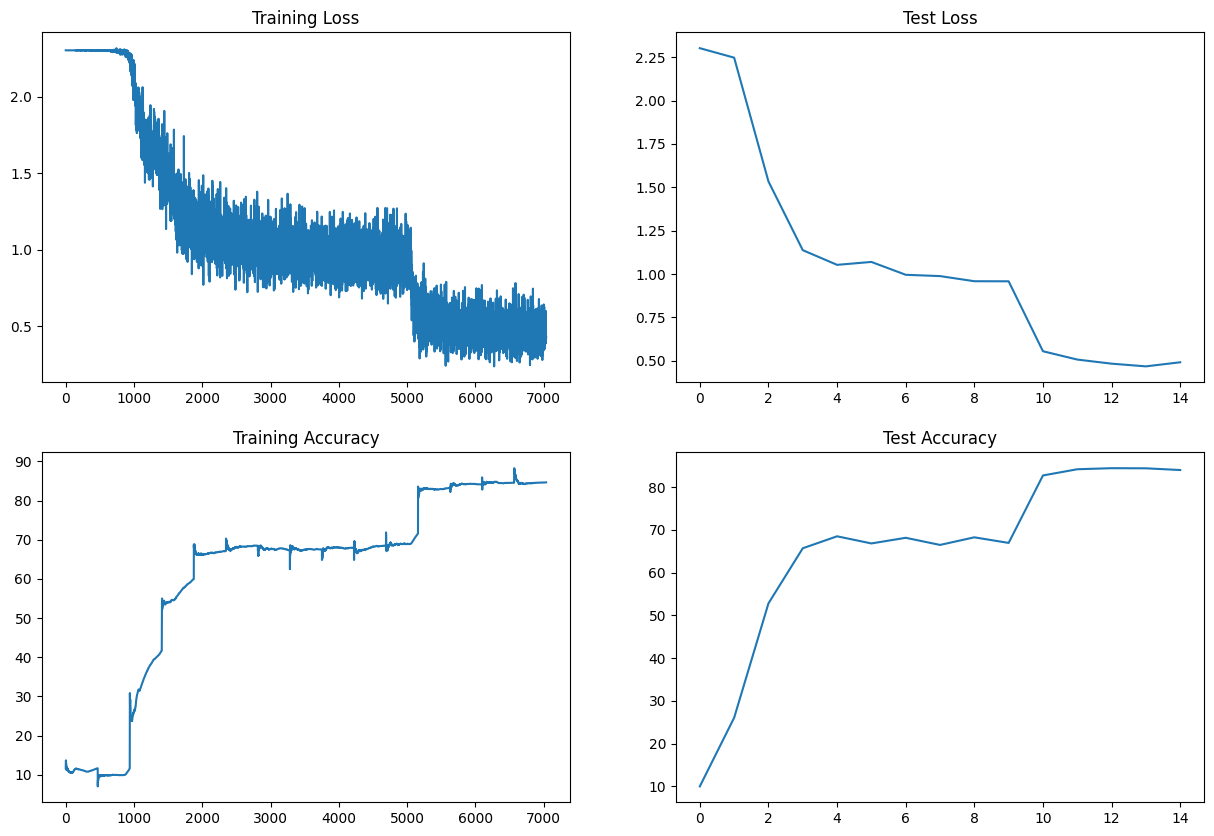

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
# Move tensors to CPU and convert to NumPy
train_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in train_losses]
train_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in train_acc]
test_losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in test_losses]
test_acc_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in test_acc]

axs[0, 0].plot(train_losses_cpu)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_cpu)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses_cpu)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_cpu)
axs[1, 1].set_title("Test Accuracy")